<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C3/C3/W3/ungraded_labs/C3_W3_Lab_4_imdb_reviews_with_GRU_LSTM_Conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

2.6.0


Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 142.82 url/s]
                                                                        

Dataset imdb_reviews downloaded and prepared to C:\Users\oeb\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [2]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [3]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [4]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [22]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Model 1: Flatten

First up is simply using a Flatten layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.

In [23]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 11526     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 1s 3ms/step - loss: 0.6399 - accuracy: 0.6156 - val_loss: 0.4415 - val_accuracy: 0.8202
Epoch 2/10
196/196 [==============================] - 0s 2ms/step - loss: 0.3370 - accuracy: 0.8597 - val_loss: 0.3408 - val_accuracy: 0.8508
Epoch 3/10
196/196 [==============================] - 0s 2ms/step - loss: 0.2069 - accuracy: 0.9270 - val_loss: 0.3584 - val_accuracy: 0.8421
Epoch 4/10
196/196 [==============================] - 0s 2ms/step - loss: 0.1171 - accuracy: 0.9701 - val_loss: 0.3942 - val_accuracy: 0.8389
Epoch 5/10
196/196 [==============================] - 0s 2ms/step - loss: 0.0550 - accuracy: 0.9927 - val_loss: 0.4422 - val_accuracy: 0.8308
Epoch 6/10
196/196 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9984 - val_loss: 0.4881 - val_accuracy: 0.8290
Epoch 7/10
196/196 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9991 - val_loss: 0.5174 - val_accuracy: 0.8302
Epoch 

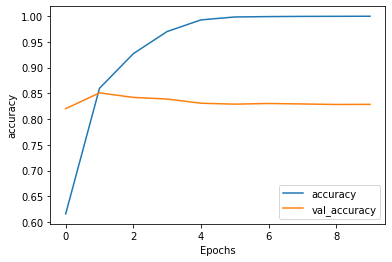

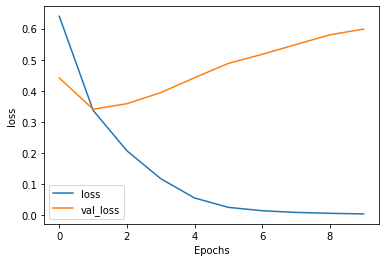

In [24]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')


# GRU

 simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy.

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epochs = 4
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/4
782/782 [==============================] - 38s 46ms/step - loss: 0.5259 - accuracy: 0.7183 - val_loss: 0.3879 - val_accuracy: 0.8274
Epoch 2/4
782/782 [==============================] - 38s 49ms/step - loss: 0.3146 - accuracy: 0.8739 - val_loss: 0.4041 - val_accuracy: 0.8157
Epoch 3/4
782/782 [==============================] - 42s 53ms/step - loss: 0.2583 - accuracy: 0.9012 - val_loss: 0.4107 - val_accuracy: 0.8137
Epoch 4/4
782/782 [==============================] - 48s 61ms/step - loss: 0.2134 - accuracy: 0.9233 - val_loss: 0.4118 - val_accuracy: 0.8303


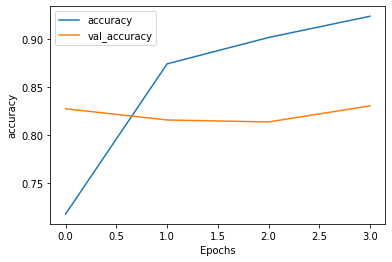

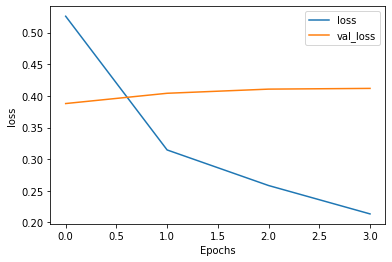

In [13]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# LSTM

In [14]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [15]:
num_epochs = 4
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/4
782/782 [==============================] - 48s 59ms/step - loss: 0.4999 - accuracy: 0.7473 - val_loss: 0.3647 - val_accuracy: 0.8469
Epoch 2/4
782/782 [==============================] - 46s 58ms/step - loss: 0.3010 - accuracy: 0.8766 - val_loss: 0.3481 - val_accuracy: 0.8473
Epoch 3/4
782/782 [==============================] - 44s 56ms/step - loss: 0.2434 - accuracy: 0.9056 - val_loss: 0.3679 - val_accuracy: 0.8387
Epoch 4/4
782/782 [==============================] - 42s 54ms/step - loss: 0.1943 - accuracy: 0.9278 - val_loss: 0.4270 - val_accuracy: 0.8306


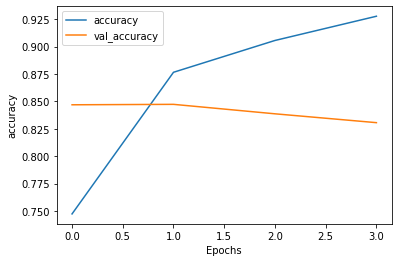

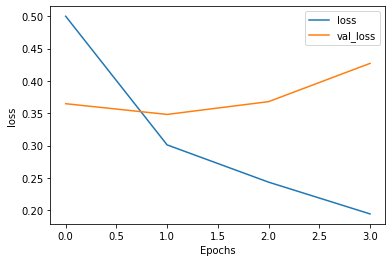

In [16]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Convolution

a convolution layer to extract features from your dataset. You will append a GlobalAveragePooling1d layer to reduce the results before passing it on to the dense layers. 
Like the model with Flatten, this also trains much faster than the ones using RNN layers like LSTM and GRU.


In [17]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 774       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


In [18]:
num_epochs = 4
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/4
782/782 [==============================] - 9s 11ms/step - loss: 0.5304 - accuracy: 0.7592 - val_loss: 0.4344 - val_accuracy: 0.8465
Epoch 2/4
782/782 [==============================] - 6s 8ms/step - loss: 0.3621 - accuracy: 0.8780 - val_loss: 0.3986 - val_accuracy: 0.8415
Epoch 3/4
782/782 [==============================] - 7s 8ms/step - loss: 0.2849 - accuracy: 0.9077 - val_loss: 0.4115 - val_accuracy: 0.8385
Epoch 4/4
782/782 [==============================] - 7s 9ms/step - loss: 0.2343 - accuracy: 0.9267 - val_loss: 0.4468 - val_accuracy: 0.8298


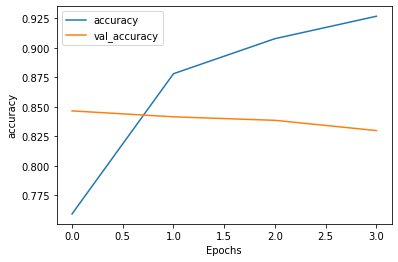

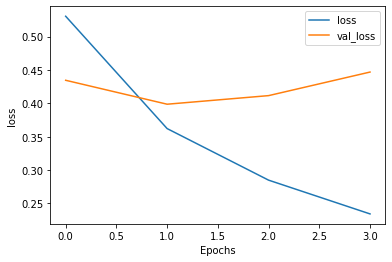

In [20]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')